In [1]:
using Pkg

# Pkg.add("DataFrames")
# Pkg.add("DotEnv")
# Pkg.add("CSV")
# Pkg.add("Plots")
# Pkg.add("Dates")
# Pkg.add("Gadfly")
# Pkg.add("StatsPlots")
# Pkg.add("StatsBase")
# Pkg.add("JSON")
# Pkg.add("Makie")


# https://www.datacamp.com/blog/introduction-machine-learning-julia
#
# Importing and handling data: CSV, DataFrames
# Plotting and output: Plots, StatsPlots, LaTeXStrings, Measures, Makie
# Statistics and Math: Random, Statistics, LinearAlgebra, StatsBase, Distributions, HypothesisTests, KernelDensity, Lasso, Combinatorics, SpecialFunctions, Roots
# Individual machine learning packages:
#    - Generalized linear models (e.g. linear regression, logistic regression): GLM
#    - Deep Learning: Flux, Knet
#    - Support vector machines: LIBSVM
#    - Decision tree, random forest, AdaBoost: DecisionTree
#    - K-nearest neighbors: NearestNeighbors
#    - K-means clustering: Clustering
#    - Principal component analysis: MultivariateStats


#### Environment configuration

In [2]:
using DotEnv

DotEnv.config("../.env", true)
alarms_data_file_path = "../" * ENV["ALARMS_DATA_FILE"]
regions_data_file_path = "../" * ENV["REGIONS_DATA_FILE"]
weather_data_file_path = "../" * ENV["WEATHER_DATA_FILE"]
tfidf_csv_path = "../" * ENV["ISW_TF_IDF_RESULT"]

"../preprocessing/results/tfidf-result.csv"

### Alarms

In [3]:
using DataFrames
using CSV

alarms = DataFrame(CSV.File(alarms_data_file_path))

println(size(alarms))

eltype.(eachcol(alarms))

(19933, 9)


9-element Vector{DataType}:
 Int64
 Int64
 String
 String
 Int64
 String31
 String31
 String31
 String7

In [4]:
# first 10 rows of the alarms
first(alarms, 10)

Row,id,region_id,region_title,region_city,all_region,start,end,clean_end,intersection_alarm_id
,Int64,Int64,String,String,Int64,String31,String31,String31,String7
1,2,3,Вінниччина,Вінниця,0,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 23:41:53,NULL
2,4,12,Львівщина,Львів,0,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 07:15:28,NULL
3,5,14,Одещина,Одеса,0,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:47:03,NULL
4,6,6,Житомирщина,Житомир,0,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 09:36:36,NULL
5,7,3,Вінниччина,Вінниця,0,2022-02-26 08:39:39,2022-02-26 10:42:41,2022-02-26 10:42:41,NULL
6,9,3,Вінниччина,Вінниця,0,2022-02-26 10:58:23,2022-02-26 11:59:40,2022-02-26 11:59:40,NULL
7,10,12,Львівщина,Львів,0,2022-02-26 13:44:44,2022-02-26 14:27:25,2022-02-26 14:27:25,NULL
8,3,16,Рівненщина,Рівненська обл.,1,2022-02-26 15:54:53,2022-02-26 16:14:46,2022-02-26 16:14:46,NULL
9,1,2,Волинь,Волинська обл.,1,2022-02-26 16:08:26,2022-02-26 16:39:26,2022-02-26 16:39:26,NULL


In [5]:
# describe dataset
describe(alarms)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,id,19504.3,1,17421.0,47547,0,Int64
2,region_id,11.1598,1,10.0,24,0,Int64
3,region_title,,Івано-Франківщина,,️Донеччина,0,String
4,region_city,,Єланець,,Южноукраїнськ,0,String
5,all_region,0.696283,0,1.0,1,0,Int64
6,start,,2022-02-25 22:55:42,,2023-01-20 22:51:11,0,String31
7,end,,2022-02-25 23:41:53,,2023-01-20 23:22:34,0,String31
8,clean_end,,2022-02-25 23:41:53,,NULL,0,String31
9,intersection_alarm_id,,10134,,NULL,0,String7


In [6]:
# first event date
println("first event date: ", minimum(alarms[!, :start]))

# max event date
println("max event date: ", maximum(alarms[!, :end]))

first event date: 2022-02-25 22:55:42


max event date: 2023-01-20 23:22:34


In [7]:
using Dates
using Statistics

transform!(alarms, [:start, :end] => ((x, y) -> DateTime.(y, "yyyy-mm-dd HH:MM:SS") - DateTime.(x, "yyyy-mm-dd HH:MM:SS")) => :duration)

transform!(alarms, :duration => (x -> Minute.(round.(Int, Dates.value.(x) / (1000 * 60)))) => :duration)

println("minimum duration: ", minimum(alarms[!, :duration]))
println("maximum duration: ", maximum(alarms[!, :duration]))

sort!(alarms, :duration, rev=false)
println(first(alarms, 10))
sort!(alarms, :duration, rev=true)
println(first(alarms, 10))

minimum duration: 0 minutes
maximum duration: 1123 minutes


10×10 DataFrame
 Row │ id     region_id  region_title      region_city        all_region  start                end                  clean_end            intersection_alarm_id  duration  
     │ Int64  Int64      String            String             Int64       String31             String31             String31             String7                Minute    
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ 18171          9  Київщина          Київська обл.               1  2022-06-21 08:51:29  2022-06-21 08:51:56  2022-06-21 08:51:56  NULL                   0 minutes
   2 │    41         12  Львівщина         Трускавець                  0  2022-02-27 19:51:41  2022-02-27 19:52:49  2022-02-27 19:52:49  NULL                   1 minute
   3 │   585         13  Миколаївщина      Первомайськ                 0  2022-03-07 05:18:04  2022-03-07 05:19:22  2022-03-07 05:19

10×10 DataFrame
 Row │ id     region_id  region_title      region_city        all_region  start                end                  clean_end            intersection_alarm_id  duration     
     │ Int64  Int64      String            String             Int64       String31             String31             String31             String7                Minute       
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ 22336          4  Дніпропетровщина  Нікополь                    0  2022-07-18 12:39:15  2022-07-19 07:22:23  2022-07-19 07:22:23  22338                  1123 minutes
   2 │ 22462          4  Дніпропетровщина  Нікополь                    0  2022-07-19 14:32:20  2022-07-20 06:25:20  2022-07-20 06:25:20  NULL                   953 minutes
   3 │  5139         23  Чернігівщина      Чернігівська обл.           1  2022-03-19 04:40:42  2022-03-19 18:55:21  2

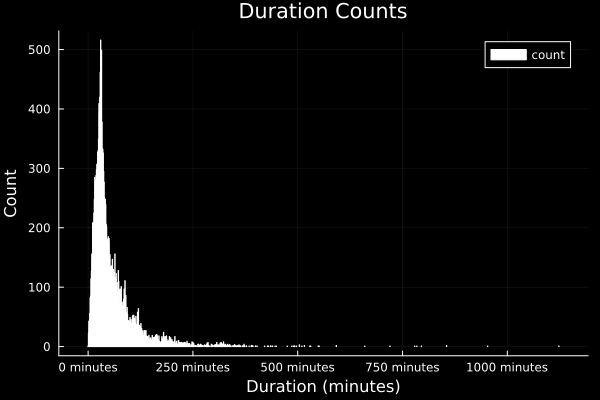

In [8]:
# visualize duration and corresponding counts using StatsPlots
using StatsPlots
using StatsBase
histogram(alarms[!, :duration], bins=100, xlabel="duration (minutes)", ylabel="counts", title="duration histogram")

# create a vector of durations
durations = alarms.duration
# count the frequency of each duration
duration_counts = countmap(durations)
# create a bar plot of the duration counts
bar(duration_counts, xlabel="Duration (minutes)", ylabel="Count", title="Duration Counts", legend=true, label="count", color="white", background_color="black", grid=true)



# working:
# using Plots
# plot(alarms[!,:duration], seriestype=:histogram, bins=100, xlabel="duration (minutes)", ylabel="counts", title="duration histogram")

In [9]:
duration_counts = countmap(alarms.duration)

# duration_counts_df = DataFrame(duration_counts, [:duration, :count])

Dict{Minute, Int64} with 387 entries:
  Minute(43)  => 206
  Minute(235) => 4
  Minute(222) => 4
  Minute(73)  => 110
  Minute(199) => 10
  Minute(32)  => 499
  Minute(285) => 2
  Minute(237) => 5
  Minute(25)  => 349
  Minute(354) => 1
  Minute(202) => 8
  Minute(160) => 16
  Minute(154) => 15
  Minute(249) => 7
  Minute(449) => 1
  Minute(330) => 1
  Minute(231) => 7
  Minute(107) => 38
  Minute(779) => 1
  ⋮           => ⋮

**TF-IDF**

In [10]:
tfidf = DataFrame(CSV.File(tfidf_csv_path))

println(size(tfidf))
println(names(tfidf))


using JSON
tfidf_keywords = tfidf[!, :Keywords]
tfidf_keywords = [JSON.parse(replace(tfidf_keywords[i], "'" => "\""), dicttype=Dict{String,Float64}) for i in 1:length(tfidf_keywords)]

(393, 3)


["Name", "Date", "Keywords"]

393-element Vector{Dict{String, Float64}}:
 Dict("action" => 0.005944434814079679, "newly" => 0.009428244396539514, "duma" => 0.02489213836265178, "western" => 0.02192130263190814, "whose" => 0.02539330043493144, "attack" => 0.029601739844895912, "favor" => 0.01002410568067112, "antitank" => 0.013311114816540974, "groupaffiliated" => 0.014777538404290462, "plan" => 0.025961256368816382…)
 Dict("irkutsk" => 0.03728916566162256, "adviser" => 0.013711522089120397, "fight" => 0.00524217911663002, "western" => 0.03193566803674621, "attack" => 0.03557794288588796, "investigator" => 0.016390091827444074, "antitank" => 0.011635239505191679, "plan" => 0.005673180643958943, "controlled" => 0.02145157557735583, "imposes" => 0.018581343745870716…)
 Dict("staterun" => 0.021959806926575152, "irkutsk" => 0.01847379554255642, "action" => 0.030890588313589967, "fight" => 0.015582479813607305, "duma" => 0.010779449216718655, "step" => 0.014304779033517413, "western" => 0.028478819100513985, "attack" => 